### Setup

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Available Device: {device}")

Available Device: cuda:0


In [ ]:
import torch.optim as optim
import numpy as np
import os

rs = 16657534

torch.manual_seed(rs)
np.random.seed(rs)

base_dir = '/kaggle/input/captcha-data/data'
train_dir = os.path.join(base_dir,'train')
sample_dir = os.path.join(base_dir,'sample')
val_dir = os.path.join(base_dir,'val')

### Dataset Setup

> One Hot encoding of characters for our model predictions <br>
> Establish train and validation datasets aswell as extraction of data

In [ ]:
charset = 'abcdefghijklmnopqrstuvwxyz0123456789'

vocab = len(charset)+1

char_to_idx = {x:i+1 for i,x in enumerate(charset) }
idx_to_char = {i+1:c for i,c in enumerate(charset)}


blank="<B>"
idx_to_char[0]=blank
char_to_idx[blank] = 0

def get_ones(label,charset,char_to_idx):
    one_hot = torch.zeros((len(label),len(charset)+1))
    for char_idx,char in enumerate(label):
        one_hot[char_idx,char_to_idx[char]] = 1.0
        
    return one_hot


In [4]:
import cv2 as cv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CaptchaDataset(Dataset):
 
    def __init__(self, datapath,transform=None):
        self.path = datapath
        self.transform = transform
        
        self.imgs = []
        self.labels = []
        
        for image_path in os.listdir(self.path):
            abs_path = os.path.join(self.path,image_path)
            self.imgs.append(abs_path)
            self.labels.append(image_path.split('.')[0])
        
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        label = self.labels[idx]
        
        img = cv.imread(img_path)
        
        if self.transform:
            img=self.transform(img)
            
        return img,get_ones(label,charset,char_to_idx)

In [5]:
batch_size=16

main_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CaptchaDataset(train_dir,main_transform)
val_dataset = CaptchaDataset(val_dir,main_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              pin_memory=True,
                              num_workers=4
                             )
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                            pin_memory=True,
                            num_workers=4
                           )
print(f"Items in Train: {len(train_dataset)}")
print(f"Items in Val: {len(val_dataset)}")

Items in Train: 856
Items in Val: 214


### Define The Model

The model used is a `CRNN` model which consists of a resnet50 backbone for feature extraction before extracted features are flattened and passed into layers of stacked `LSTMs` for prediction of characters

In [ ]:
from torch.nn import init
from torchvision.models import ResNet50_Weights,resnet50
class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes,lstm_count):
        super(StackedLSTM, self).__init__()
        
        self.lstm_count = lstm_count
        self.classes = num_classes
        self.num_layers = 1
        self.stacked_lstms = nn.ModuleList([nn.LSTM(input_size if l == 0 else hidden_size*2,hidden_size,self.num_layers,bidirectional=True,batch_first=True) for l in range(lstm_count)])
        
    def forward(self,x):
        prev = x
    
        for j in range(self.lstm_count):
            prev,_ = self.stacked_lstms[j](prev)

        return prev
    
class CRNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(CRNN, self).__init__()
        
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model = torch.nn.Sequential(*(list(model.children())[:-3]))

        
        self.lstm = StackedLSTM(1024*4 , 128,num_classes + 1,2) # Input: conv height*conv output size
        self.fc = nn.Linear(128 * 2, num_classes + 1)

        self.softmax = nn.LogSoftmax(2)
        self._init_weights()
        

    def forward(self, x):
        conv_out = self.model(x) 
 
        batch_size, output_size, height, width = conv_out.size()

        conv_out = conv_out.view(batch_size, width, output_size * height)
        lstm_out = self.lstm(conv_out)

        logits = self.fc(lstm_out)
        logits = logits.permute(1,0,2)

        out = self.softmax(logits)
        
        return out
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)
        

In [38]:
num_classes = 36 
crnn = CRNN(num_classes).to(device)
ctc = nn.CTCLoss(blank=0).to(device)
optimizer = optim.Adam(crnn.parameters(), lr=3e-4)

### Train

In [39]:
def train(model, dataloader, criterion, optimizer, num_epochs):
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for images, labels in dataloader:
      
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            outputs = model(images) # torch.Size([7, 16, 37])
            #print(outputs,outputs.size(),labels.size())
            
            out_lengths = torch.full((outputs.size(1),),outputs.size(0), dtype=torch.int32).to(device)
            target_lengths = torch.full((labels.size(0),),labels.size(1), dtype=torch.int32).to(device)
            
            indices = torch.argmax(labels, 2).view(-1).to(device)
    
            
            loss = criterion(outputs,indices,out_lengths,target_lengths)
    
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        with torch.no_grad():

                val_loss = 0
                model.eval()
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    
                    out_lengths = torch.full((outputs.size(1),),outputs.size(0), dtype=torch.int32).to(device)
                    target_lengths = torch.full((labels.size(0),),labels.size(1), dtype=torch.int32).to(device)
                    
                    indices = torch.argmax(labels, 2).view(-1).to(device)
                    loss = criterion(outputs,indices,out_lengths,target_lengths)
  

                    val_loss += loss.item()
                
            
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}, Val Loss: {val_loss / len(val_dataloader)}")


In [40]:
train(crnn, train_dataloader, ctc, optimizer, num_epochs=30)

Epoch 1/30, Loss: 3.9565336969163685, Val Loss: 3.2828717061451504
Epoch 2/30, Loss: 3.2593910649970725, Val Loss: 3.247110332761492
Epoch 3/30, Loss: 3.2413243276101573, Val Loss: 3.235078913824899
Epoch 4/30, Loss: 3.233542835270917, Val Loss: 3.222150649343218
Epoch 5/30, Loss: 3.1644027498033314, Val Loss: 3.200665303639003
Epoch 6/30, Loss: 2.9511993637791387, Val Loss: 2.8571962458746776
Epoch 7/30, Loss: 2.6022854425289013, Val Loss: 2.422172256878444
Epoch 8/30, Loss: 2.113392291245637, Val Loss: 1.909886964729854
Epoch 9/30, Loss: 1.4973368291501645, Val Loss: 1.1519074950899397
Epoch 10/30, Loss: 0.7218240372560643, Val Loss: 0.5248179648603711
Epoch 11/30, Loss: 0.2948062050121802, Val Loss: 0.23830904918057577
Epoch 12/30, Loss: 0.12314036792075192, Val Loss: 0.16130418649741582
Epoch 13/30, Loss: 0.06889319509543755, Val Loss: 0.09071918789829526
Epoch 14/30, Loss: 0.045842609678705536, Val Loss: 0.07271472896848406
Epoch 15/30, Loss: 0.03425601597323462, Val Loss: 0.06646

### Evaluate Model

Accuracy is determined by the percentage of correct full captcha predictions

In [41]:
from itertools import zip_longest
def eval_model(model):
    
    model.eval()
    l_strings=[]
    strings=[]
    
    with torch.no_grad():
        for images,labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            
            l_indices = torch.argmax(labels,2)
            
            
        
            for ls,s in zip_longest(l_indices,torch.argmax(out.permute(1,0,2).log_softmax(2),2), fillvalue=[]):
                st = ''
                lst = ''
                for lc,c in zip_longest(ls,s, fillvalue=0):
                    lst += idx_to_char[lc.item()] if lc!=0 else ''
                    st += idx_to_char[c.item()] if c !=0 else ''
                l_strings.append(lst)
                strings.append(st)
            
    return np.array(l_strings),np.array(strings)
                
def calc_accuracy(true,preds):
    correct=0
    for t,p in zip(true,preds):
        if t==p:
            correct+=1
    acc = correct/len(true)
    print(f"Test Accuracy (full label predictions): {correct/len(true)}")
    return acc

true,preds = eval_model(crnn)

acc = calc_accuracy(true,preds)
            
            


Test Accuracy (full label predictions): 0.9813084112149533


### Save and Visualise Results

In [42]:
torch.save(crnn,f'{acc:4f}-model.pt')

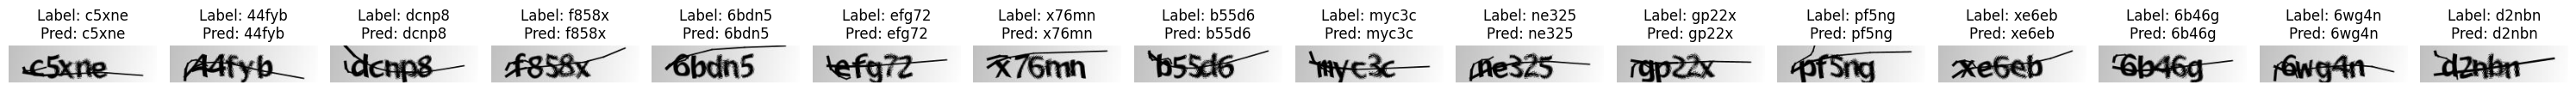

In [43]:
import matplotlib.pyplot as plt
def visualise_batch(model):
    
    model.eval()
    l_strings=[]
    strings=[]
    batch_images=None
    
    with torch.no_grad():
        for images,labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            batch_images=images
            
            
        
            for ls,s in zip_longest(torch.argmax(labels,2),torch.argmax(out.permute(1,0,2).log_softmax(2),2), fillvalue=[]):
                st = ''
                lst = ''
                for lc,c in zip_longest(ls,s, fillvalue=0):
                    lst += idx_to_char[lc.item()] if lc!=0 else ''
                    st += idx_to_char[c.item()] if c !=0 else ''
                l_strings.append(lst)
                strings.append(st)
            break
    
    batch_images = batch_images.cpu()

    fig, axes = plt.subplots(1, batch_images.size(0), figsize=(30, 10))
    
    if batch_size == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        img = batch_images[i].permute(1, 2, 0)
        ax.imshow(img)
        ax.set_title(f"Label: {l_strings[i]}\nPred: {strings[i]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    return
   
visualise_batch(crnn)    